# Trigram LM model

Implement the trigram LM model using the probability and NN using torch

## Frequency matrix method

In [135]:
with open('../names.txt', 'r') as file:
    names = file.read().splitlines()

len(names)

32033

### Step 1: Create the trigrams

In [136]:
trigram_dict = {}

for name in names:
    name = ['.'] + list(name) + ['.']

    for ch1, ch2, ch3 in zip(name, name[1:], name[2:]):
        bigram = ch1 + ch2
        trigram = (bigram, ch3)
        trigram_dict[trigram] = trigram_dict.get(trigram, 0) + 1

print(f"No. of trigrams: {len(trigram_dict)}")

No. of trigrams: 6037


In [137]:
sorted(trigram_dict.keys())[1000:1200]

[('ca', 'r'),
 ('ca', 's'),
 ('ca', 't'),
 ('ca', 'u'),
 ('ca', 'v'),
 ('ca', 'y'),
 ('ca', 'z'),
 ('cc', '.'),
 ('cc', 'a'),
 ('cc', 'e'),
 ('cc', 'h'),
 ('cc', 'i'),
 ('cc', 'l'),
 ('cc', 'o'),
 ('cc', 'r'),
 ('cd', 'e'),
 ('ce', '.'),
 ('ce', 'a'),
 ('ce', 'b'),
 ('ce', 'c'),
 ('ce', 'd'),
 ('ce', 'e'),
 ('ce', 'i'),
 ('ce', 'k'),
 ('ce', 'l'),
 ('ce', 'm'),
 ('ce', 'n'),
 ('ce', 'o'),
 ('ce', 'p'),
 ('ce', 'r'),
 ('ce', 's'),
 ('ce', 't'),
 ('ce', 'u'),
 ('ce', 'v'),
 ('ce', 'y'),
 ('ce', 'z'),
 ('cg', 'r'),
 ('cg', 'u'),
 ('ch', '.'),
 ('ch', 'a'),
 ('ch', 'e'),
 ('ch', 'i'),
 ('ch', 'l'),
 ('ch', 'm'),
 ('ch', 'n'),
 ('ch', 'o'),
 ('ch', 'r'),
 ('ch', 's'),
 ('ch', 'u'),
 ('ch', 'y'),
 ('ci', '.'),
 ('ci', 'a'),
 ('ci', 'c'),
 ('ci', 'd'),
 ('ci', 'e'),
 ('ci', 'f'),
 ('ci', 'i'),
 ('ci', 'j'),
 ('ci', 'l'),
 ('ci', 'm'),
 ('ci', 'n'),
 ('ci', 'o'),
 ('ci', 'p'),
 ('ci', 'r'),
 ('ci', 's'),
 ('ci', 't'),
 ('ci', 'u'),
 ('ci', 'v'),
 ('cj', '.'),
 ('cj', 'a'),
 ('ck', '.'),
 ('ck'

### Step 2: Create the stoi, itos, btoi, itob 

b -> bigram

In [138]:
chars = sorted(list(set("".join(name for name in names))))
chars

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [139]:
stoi, itos, btoi, itob = {}, {}, {}, {}

stoi['.'] = 0
itos[0] = '.'

for i, char in enumerate(chars):
    stoi[char] = i + 1
    itos[i + 1] = char

cnt = 0
btoi['..'] = 0
itob[0] = '..'
cnt += 1

for ch1 in (['.'] + chars):
    for ch2 in chars:
        bigram = ch1 + ch2
        btoi[bigram] = cnt
        itob[cnt] = bigram
        cnt += 1

In [140]:
sorted(btoi.keys())[200:250]

['gr',
 'gs',
 'gt',
 'gu',
 'gv',
 'gw',
 'gx',
 'gy',
 'gz',
 'ha',
 'hb',
 'hc',
 'hd',
 'he',
 'hf',
 'hg',
 'hh',
 'hi',
 'hj',
 'hk',
 'hl',
 'hm',
 'hn',
 'ho',
 'hp',
 'hq',
 'hr',
 'hs',
 'ht',
 'hu',
 'hv',
 'hw',
 'hx',
 'hy',
 'hz',
 'ia',
 'ib',
 'ic',
 'id',
 'ie',
 'if',
 'ig',
 'ih',
 'ii',
 'ij',
 'ik',
 'il',
 'im',
 'in',
 'io']

### Step 3: Create the frequency matrix

In [141]:
import torch

freqs = torch.zeros((len(btoi), len(stoi)), dtype=torch.int32)
freqs.shape

torch.Size([703, 27])

In [142]:
for trigram, freq in trigram_dict.items():
    bigram, ch = trigram[0], trigram[1]
    
    idx1 = btoi[bigram]
    idx2 = stoi[ch]

    freqs[idx1][idx2] = freq

# Smoothen the matrix
freqs += 1

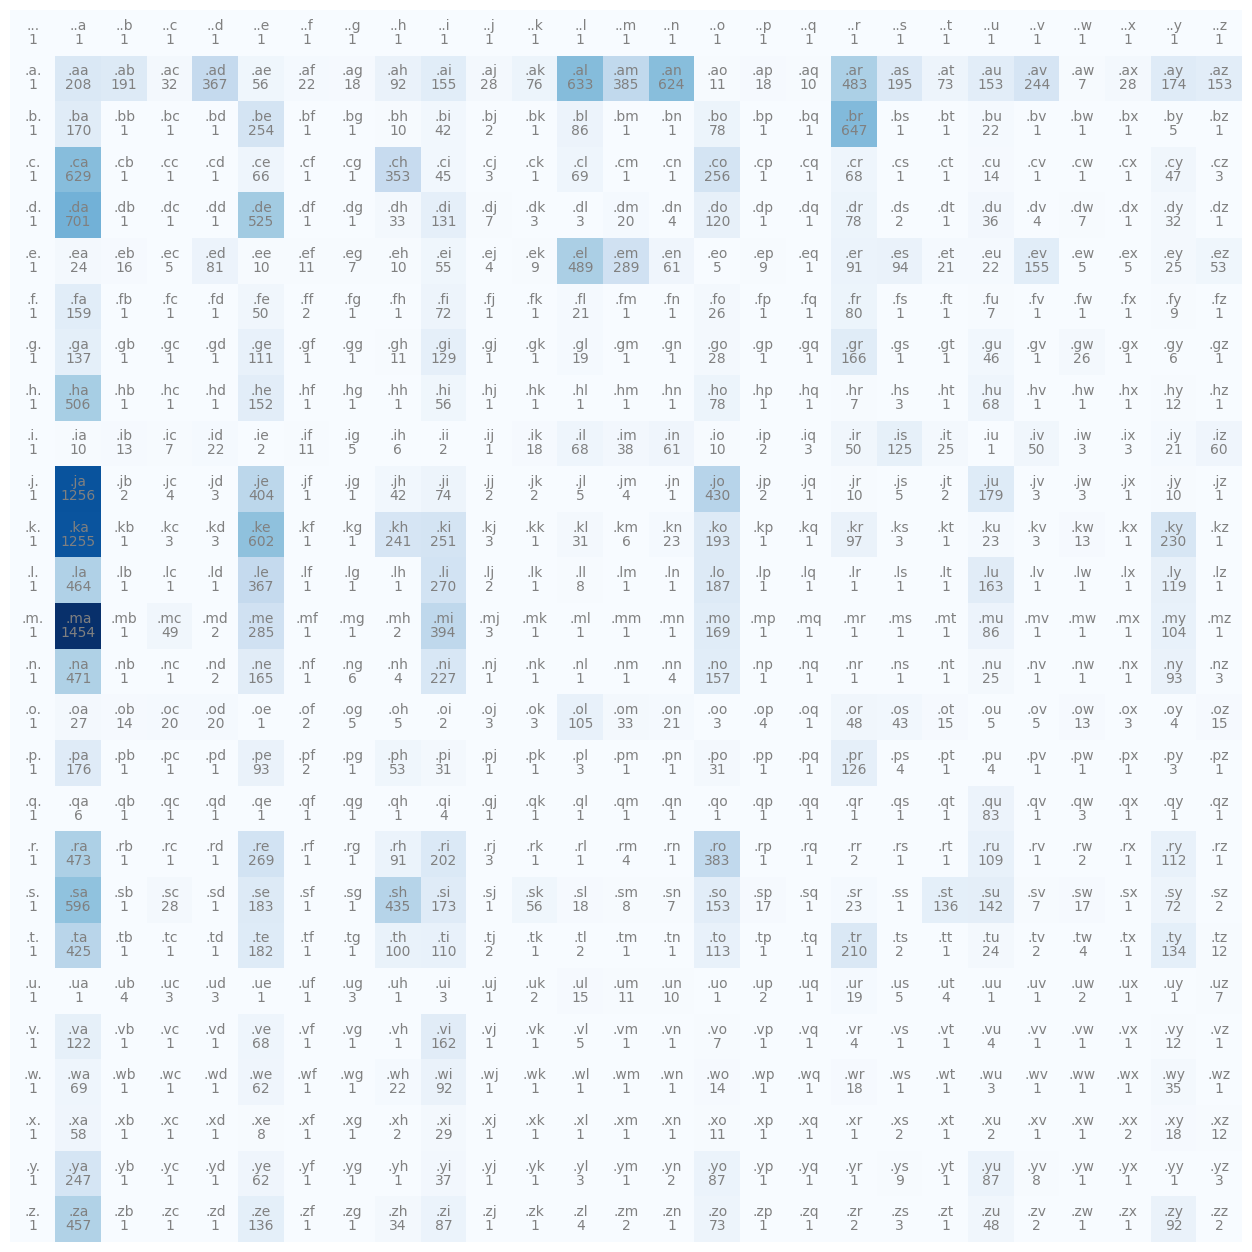

In [143]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(freqs[:27,:], cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itob[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, freqs[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

### Step 4: Create the probability matrix

In [144]:
P = freqs.float()
P.shape

torch.Size([703, 27])

In [145]:
P.sum(dim=1, keepdim=True).shape

torch.Size([703, 1])

In [146]:
# 702 * 27
# 702 * 1 -> sum of column valus

In [147]:
P = P / P.sum(dim=1, keepdim=True)
P.shape

torch.Size([703, 27])

In [148]:
P[65].sum()

tensor(1.)

### Step 5: Do sampling from this

In [149]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5): #Lets sample 5 names
    curr_bigram, curr_name = "..", ""

    while True:
        curr_idx = btoi[curr_bigram]
         
        sample_idx = torch.multinomial(P[curr_idx], num_samples=1, replacement=True, generator=g).item()
        sample_char = itos[sample_idx]

        if sample_char == ".":
            break
        
        curr_bigram += sample_char
        curr_bigram = curr_bigram[1:]
        curr_name += sample_char

        # print(curr_bigram, curr_name)

    print(curr_name)

ce
za
zogh
uriana
kaydnevonimittain


### Step 6: Calculate NLL for a name

In [150]:
def calculate_nll(og_name):
    nll, n = 0, 0

    name = ['.'] + list(og_name) + ['.']

    for ch1, ch2, ch3 in zip(name, name[1:], name[2:]):
        bigram = ch1 + ch2
        i1, i2 = btoi[bigram], stoi[ch3]
        nll += -torch.log(P[i1][i2]).item()
        n += 1

    nll = nll/n

    return nll

In [151]:
og_name = 'andrej'
nll = calculate_nll(og_name)
print(f"{og_name} has a NLL of: {nll}")

andrej has a NLL of: 2.4700524608294168


In [152]:
og_name = 'soham'
nll = calculate_nll(og_name)
print(f"{og_name} has a NLL of: {nll}")

soham has a NLL of: 2.500639033317566


In [153]:
og_name = 'andrejq'
nll = calculate_nll(og_name)
print(f"{og_name} has a NLL of: {nll}")

andrejq has a NLL of: 2.9169624022075107


In [154]:
og_name = 'emma'
nll = calculate_nll(og_name)
print(f"{og_name} has a NLL of: {nll}")

emma has a NLL of: 1.8591869920492172


In [155]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5): #Lets sample 5 names
    curr_bigram, curr_name = "..", ""

    while True:
        curr_idx = btoi[curr_bigram]
         
        sample_idx = torch.multinomial(P[curr_idx], num_samples=1, replacement=True, generator=g).item()
        sample_char = itos[sample_idx]

        if sample_char == ".":
            break
        
        curr_bigram += sample_char
        curr_bigram = curr_bigram[1:]
        curr_name += sample_char

        # print(curr_bigram, curr_name)

    nll = calculate_nll(curr_name)
    print(f"Generated name: {curr_name} has a NLL of: {nll}")

Generated name: ce has a NLL of: 2.034263700246811
Generated name: za has a NLL of: 1.465399831533432
Generated name: zogh has a NLL of: 2.542527675628662
Generated name: uriana has a NLL of: 1.404889573653539
Generated name: kaydnevonimittain has a NLL of: 2.2905726853538964


### Step 7: Compute NLL of the full dataset

In [156]:
total_nll, n = 0, 0

for name in names:
    name = ['.'] + list(name) + ['.']
    for ch1, ch2, ch3 in zip(name, name[1:], name[2:]):
        bigram = ch1 + ch2
        i1, i2 = btoi[bigram], stoi[ch3]
        total_nll += -torch.log(P[i1][i2]).item()
        n += 1

avg_nll = total_nll/n

print(f"Average NLL of the train dataset for prob matrix: {avg_nll}")

Average NLL of the train dataset for prob matrix: 2.0930798565434383


## NN method

In [157]:
with open('../names.txt', 'r') as file:
    names = file.read().splitlines()

len(names)

32033

### Step 1: Create the training data `xs`. `ys` and `xenc` (one-hot encoding)

In [158]:
chars = sorted(list(set("".join(name for name in names))))
chars

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [159]:
stoi, itos, btoi, itob = {}, {}, {}, {}

stoi['.'] = 0
itos[0] = '.'

for i, char in enumerate(chars):
    stoi[char] = i + 1
    itos[i + 1] = char

cnt = 0
btoi['..'] = cnt
itob[cnt] =  '..'
cnt += 1

for ch1 in (['.'] + chars):
    for ch2 in chars:
        bigram = ch1 + ch2
        btoi[bigram] = cnt
        itob[cnt] = bigram
        cnt += 1

In [160]:
len(stoi), len(btoi)

(27, 703)

In [161]:
xs, ys = [], []

for name in names[:1]:
    name = ['.'] + list(name) + ['.']

    for ch1, ch2, ch3 in zip(name, name[1:], name[2:]):
        bigram = ch1 + ch2
        print(bigram, ch3)
        idx1, idx2 = btoi[bigram], stoi[ch3]

        xs.append(idx1)
        ys.append(idx2)

xs, ys

.e m
em m
mm a
ma .


([5, 143, 351, 339], [13, 13, 1, 0])

In [162]:
import torch

xs = torch.Tensor(xs).long()
ys = torch.Tensor(ys).long()

xs, ys

(tensor([  5, 143, 351, 339]), tensor([13, 13,  1,  0]))

In [163]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=len(btoi)).float()
xenc.shape

torch.Size([4, 703])

### Step 2: Initialize the parameters

In [164]:
g = torch.Generator().manual_seed(2147483647)

W = torch.randn((len(btoi), len(stoi)), generator=g, dtype=torch.float32, requires_grad=True)
W.shape

torch.Size([703, 27])

### Step 3: Do a forward pass, exponentiate and normalize

In [165]:
logits = xenc @ W
counts = torch.exp(logits)
probs = counts / (counts.sum(dim=1, keepdim=True))
probs.shape

torch.Size([4, 27])

In [166]:
probs[1].sum()

tensor(1.0000, grad_fn=<SumBackward0>)

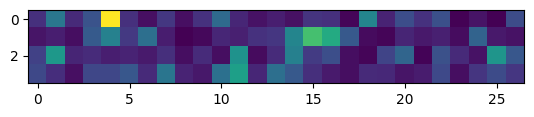

In [167]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(probs.detach().numpy())

### Step 4: Compute NLL

In [168]:
ys

tensor([13, 13,  1,  0])

In [169]:
pred = probs[torch.arange(0, len(ys)), ys]
pred

tensor([0.0181, 0.0329, 0.1065, 0.0446], grad_fn=<IndexBackward0>)

In [170]:
nll = -torch.log(pred).mean()
nll

tensor(3.1940, grad_fn=<NegBackward0>)

### Step 5: Do backward pass and update weights

In [171]:
nll.backward()

In [172]:
with torch.no_grad():
    W -= 0.1 * W.grad

### Step 6: Check NLL and if it actually goes down

In [173]:
logits = xenc @ W
counts = torch.exp(logits)
probs = counts / (counts.sum(dim=1, keepdim=True))
pred = probs[torch.arange(0, len(ys)), ys]
nll = -torch.log(pred).mean()
nll

tensor(3.1699, grad_fn=<NegBackward0>)

### Finally bring everything together

In [174]:
xs, ys, n = [], [], 0

for name in names:
    name = ['.'] + list(name) + ['.']

    for ch1, ch2, ch3 in zip(name, name[1:], name[2:]):
        bigram = ch1 + ch2
        # print(bigram, ch3)
        idx1, idx2 = btoi[bigram], stoi[ch3]

        xs.append(idx1)
        ys.append(idx2)

        n += 1

print(f"No of trigrams in the data: {n}") 

No of trigrams in the data: 196113


In [175]:
xs = torch.Tensor(xs).long()
ys = torch.Tensor(ys).long()

xs.shape, ys.shape

(torch.Size([196113]), torch.Size([196113]))

In [176]:
xenc = F.one_hot(xs, num_classes=len(btoi)).float()
xenc.shape

torch.Size([196113, 703])

In [180]:
g = torch.Generator().manual_seed(2147483647)

W = torch.randn((len(btoi), len(stoi)), generator=g, dtype=torch.float32, requires_grad=True)

In [181]:
for i in range(100):
    W.grad = None

    logits = xenc @ W
    counts = torch.exp(logits)
    probs = counts / (counts.sum(dim=1, keepdim=True))

    pred = probs[torch.arange(0, len(ys)), ys]

    nll = -torch.log(pred).mean()

    nll.backward()
    with torch.no_grad():
        W -= 100*W.grad

    print(f"Epoch {i+1} NLL: {nll.item()}")

Epoch 1 NLL: 3.741147756576538
Epoch 2 NLL: 3.589912176132202
Epoch 3 NLL: 3.4578566551208496
Epoch 4 NLL: 3.345853567123413
Epoch 5 NLL: 3.2525243759155273
Epoch 6 NLL: 3.1741490364074707
Epoch 7 NLL: 3.1070914268493652
Epoch 8 NLL: 3.0488810539245605
Epoch 9 NLL: 2.997884511947632
Epoch 10 NLL: 2.9528868198394775
Epoch 11 NLL: 2.9128904342651367
Epoch 12 NLL: 2.8770575523376465
Epoch 13 NLL: 2.844691514968872
Epoch 14 NLL: 2.8152337074279785
Epoch 15 NLL: 2.7882423400878906
Epoch 16 NLL: 2.7633678913116455
Epoch 17 NLL: 2.7403323650360107
Epoch 18 NLL: 2.718912363052368
Epoch 19 NLL: 2.698923349380493
Epoch 20 NLL: 2.68021297454834
Epoch 21 NLL: 2.6626527309417725
Epoch 22 NLL: 2.6461336612701416
Epoch 23 NLL: 2.630560874938965
Epoch 24 NLL: 2.615854024887085
Epoch 25 NLL: 2.601940155029297
Epoch 26 NLL: 2.588756799697876
Epoch 27 NLL: 2.576246500015259
Epoch 28 NLL: 2.564358711242676
Epoch 29 NLL: 2.5530476570129395
Epoch 30 NLL: 2.5422708988189697
Epoch 31 NLL: 2.531992197036743
Ep

### Sample from this distribution

In [182]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5): #Lets sample 5 names
    curr_bigram, curr_name = "..", ""

    while True:
        curr_idx = torch.Tensor([btoi[curr_bigram]]).long()
        curr_idx_enc = F.one_hot(curr_idx, num_classes=len(btoi)).float()

        logits = curr_idx_enc @ W
        counts = torch.exp(logits)
        probs = counts / (counts.sum(dim=1, keepdim=True))

        # Sample from this
        sample_idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        sample_char = itos[sample_idx]

        if sample_char == ".":
            break

        curr_bigram += sample_char
        curr_bigram = curr_bigram[1:]
        curr_name += sample_char

    print(curr_name)

zexzmcqugh
uriana
otyharlinimiltain
luwak
ka


## Try Normalization

In [183]:
g = torch.Generator().manual_seed(2147483647)

W = torch.randn((len(btoi), len(stoi)), generator=g, dtype=torch.float32, requires_grad=True)

In [184]:
for i in range(200):
    W.grad = None

    logits = xenc @ W
    counts = torch.exp(logits)
    probs = counts / (counts.sum(dim=1, keepdim=True))

    pred = probs[torch.arange(0, len(ys)), ys]

    nll_reg = -torch.log(pred).mean() + 0.01 * ((W.data)**2).mean()

    nll_reg.backward()
    with torch.no_grad():
        W -= 75*W.grad

    print(f"Epoch {i+1} NLL: {nll_reg.item()}")

Epoch 1 NLL: 3.7512075901031494
Epoch 2 NLL: 3.636749505996704
Epoch 3 NLL: 3.5328078269958496
Epoch 4 NLL: 3.4398741722106934
Epoch 5 NLL: 3.358078956604004
Epoch 6 NLL: 3.2866289615631104
Epoch 7 NLL: 3.224013090133667
Epoch 8 NLL: 3.1686246395111084
Epoch 9 NLL: 3.119159698486328
Epoch 10 NLL: 3.074662685394287
Epoch 11 NLL: 3.03442120552063
Epoch 12 NLL: 2.9978744983673096
Epoch 13 NLL: 2.9645490646362305
Epoch 14 NLL: 2.9340338706970215
Epoch 15 NLL: 2.905968427658081
Epoch 16 NLL: 2.880039691925049
Epoch 17 NLL: 2.855977773666382
Epoch 18 NLL: 2.8335561752319336
Epoch 19 NLL: 2.8125829696655273
Epoch 20 NLL: 2.7928977012634277
Epoch 21 NLL: 2.7743661403656006
Epoch 22 NLL: 2.756873607635498
Epoch 23 NLL: 2.7403225898742676
Epoch 24 NLL: 2.7246298789978027
Epoch 25 NLL: 2.7097229957580566
Epoch 26 NLL: 2.6955385208129883
Epoch 27 NLL: 2.682020664215088
Epoch 28 NLL: 2.6691205501556396
Epoch 29 NLL: 2.6567940711975098
Epoch 30 NLL: 2.645002603530884
Epoch 31 NLL: 2.633711099624634


In [187]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5): #Lets sample 5 names
    curr_bigram, curr_name = "..", ""

    while True:
        curr_idx = torch.Tensor([btoi[curr_bigram]]).long()
        curr_idx_enc = F.one_hot(curr_idx, num_classes=len(btoi)).float()

        logits = curr_idx_enc @ W
        counts = torch.exp(logits)
        probs = counts / (counts.sum(dim=1, keepdim=True))

        # Sample from this
        sample_idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        sample_char = itos[sample_idx]

        if sample_char == ".":
            break

        curr_bigram += sample_char
        curr_bigram = curr_bigram[1:]
        curr_name += sample_char

    print(curr_name)

zexzmcquajkuriana
otyharlinimilea
orakayk
ka
or
